In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

headers = ['user_id', 'movie_id', 'rating', 'time']
data = pd.read_table('ml-100k/u.data', sep='\t', header=None, names=headers)

In [132]:
data.head()

,user_id,movie_id,rating,time
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [149]:
user = data['user_id'].values
movie = data['movie_id'].values
rating = data['rating'].values

In [150]:
def build_R(user, movie, rating):
    R = np.zeros((943,1682),dtype=int)
    for i in range(len(user)):
        R[user[i]-1, movie[i]-1] = rating[i]
    return R

In [151]:
R = build_R(user, movie, rating)
W = (R!=0)
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)
W

array([[ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [152]:
def get_error(R, U, V, W):
    return np.sum((W * (R - np.dot(U, V))**2))

# Part 1 (No Cross Validation)

min error: 503898.924559


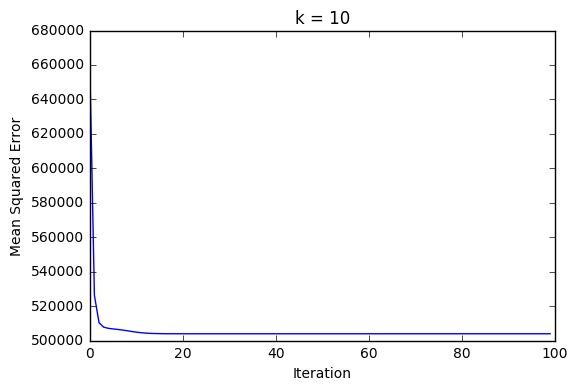

min error: 336490.431735


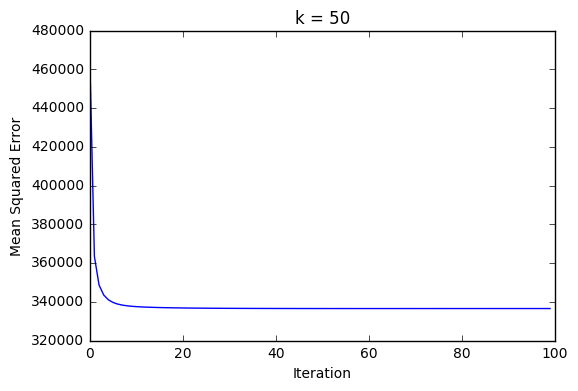

min error: 221241.557965


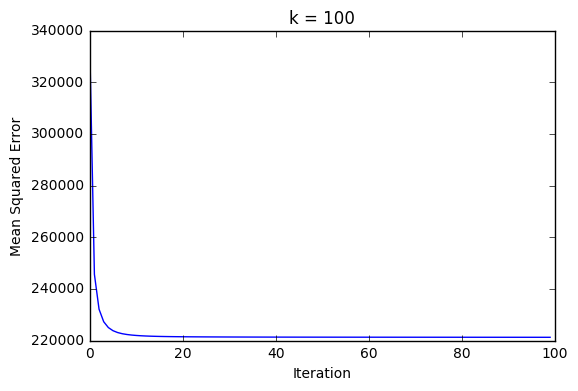

min error: 6567.09664451


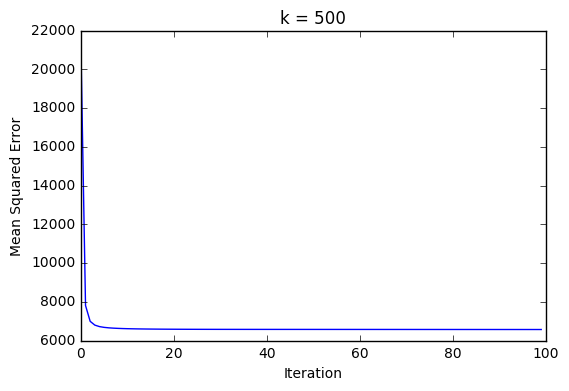

In [177]:
m, n = R.shape
n_iterations = 100
min_error = np.inf
for k in (10, 50, 100, 500):
    U = 5 * np.random.rand(m, k)
    V = 5 * np.random.rand(k, n)
    errors = []
    for it in range(n_iterations):
        U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
        V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
        error = get_error(R, U, V, W)                
        errors.append(error)
        
        # find the R_hat with min error
        if error<min_error:
            min_error = error
            R_hat = np.dot(U, V)

    print("min error:", min_error)
    plt.plot(errors)
    plt.title("k = %d" % k)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Iteration")
    plt.show()

In [173]:
R_hat-=np.min(R_hat)
R_hat *= float(5) / np.max(R_hat)
R_hat

array([[ 4.55662734,  2.9495322 ,  3.76910553, ...,  0.77302701,
         0.7740361 ,  0.7740361 ],
       [ 3.69594243,  0.8985648 ,  1.08923481, ...,  0.748916  ,
         0.7740361 ,  0.7740361 ],
       [ 0.8336318 ,  0.9020496 ,  0.76757197, ...,  0.79046588,
         0.7740361 ,  0.7740361 ],
       ..., 
       [ 0.82002187,  0.82085306,  0.80092088, ...,  0.78398615,
         0.7740361 ,  0.7740361 ],
       [ 0.78808888,  1.076272  ,  0.83440302, ...,  0.77164777,
         0.7740361 ,  0.7740361 ],
       [ 0.77217154,  0.90263895,  0.77365473, ...,  0.79173888,
         0.7740361 ,  0.7740361 ]])

# Part 2 (Cross Validation)

In [179]:
from sklearn.model_selection import KFold

def validation_error(test_user, test_movie, R, test_rating):
    error = 0
    for i in range(len(test_user)):
        error += np.absolute(test_rating[i]-R[test_user[i]-1, test_movie[i]-1])
    return error

# 10-fold cross validation
m, n = R.shape
n_iterations = 100
kf = KFold(n_splits=10)

for k in (10, 50, 100, 500):
    count = 1
    v_errors = []
    for train, test in kf.split(user):
        train_user = user[train]
        train_movie = movie[train]
        train_rating = rating[train]
        test_user = user[test]
        test_movie = movie[test]
        test_rating = rating[test]

        R = build_R(train_user, train_movie, train_rating)
        W = (R!=0)
        W[W == True] = 1
        W[W == False] = 0
        W = W.astype(np.float64, copy=False)

        U = 5 * np.random.rand(m, k) 
        V = 5 * np.random.rand(k, n)
        errors = []
        min_error = np.inf
        for it in range(n_iterations):
            U = np.linalg.solve(np.dot(V, V.T), np.dot(V, R.T)).T
            V = np.linalg.solve(np.dot(U.T, U), np.dot(U.T, R)) 
            error = get_error(R, U, V, W)                
            errors.append(error)
            if error<min_error:
                min_error = error
                min_test = test
                R_hat = np.dot(U, V)

        R_hat -= np.min(R_hat)
        R_hat *= float(5) / np.max(R_hat)
#         v_error = validation_error(test_user, test_movie, R_hat, test_rating)
#         print("k=%d, average error of test %d:%f"%(k, count, v_error/len(test_user)))
#         v_errors.append(v_error)
#         count += 1
#     print("average error of k=%d system:%f"%(k, sum(v_errors)/10))
    